### В этой версии просто добавим название Название фильма к описанию и увеличим количество токенов

In [1]:
import random
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf

# Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizerFast

from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [3]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv.zip
./data/train.csv
./data/test.csv
./data/train.csv.zip


# Data
#### TRAIN

In [4]:
DATA_PATH = './data/'
PATH      = './working/'

In [5]:
train = pd.read_csv(DATA_PATH+'train.csv',)

In [6]:
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 500)

In [7]:
train.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,"Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to a..."
1,Cupid (1997),thriller,A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
2,"Young, Wild and Wonderful (1980)",adult,"As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, durin..."
3,The Secret Sin (1915),drama,"To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstresses . An invalid, Grace falls prey to the temptations of Chinatown opium and becomes an addict, a ..."
4,The Unrecovered (2007),drama,"The film's title refers not only to the un-recovered bodies at ground zero, but also to the state of the nation at large. Set in the hallucinatory period of time between September 11 and Hallowee..."


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

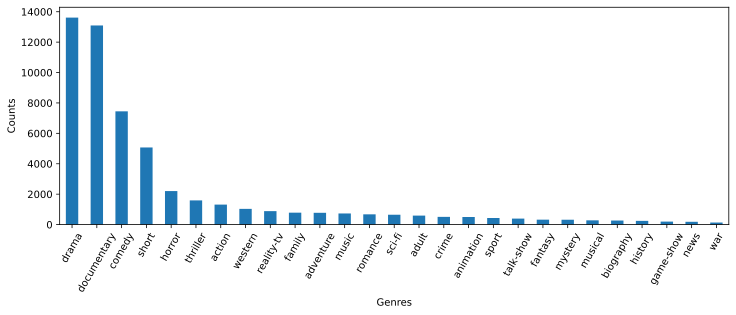

In [9]:
train.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

In [10]:
train.genre.nunique()

27

#### Test

In [11]:
test = pd.read_csv(DATA_PATH+'test.csv',)
test.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina's birth, he feels he has lost the privileged position of ""prince"" of the house..."
2,Off the Beaten Track (2010),"One year in the life of Albin and his family of shepherds in the North of Transylvania. In direct cinema style, this documentary follows their day to day routines, and their struggle to adapt to ..."
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his brother for about 10 years and has a serious cancer. Diego is a talented film director with difficulty to deal with his sickness, which is making hi..."
4,Er nu zhai (1955),"Before he was known internationally as a martial arts superstar, Bruce Lee had appeared in a handful of Hong Kong films as a child star in the 1940s/50s. One of these early films was The More the..."


In [12]:
train.text[1]

' A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.'

In [13]:
train.name[1]

' Cupid (1997) '

In [14]:
train.text = train.text.apply(lambda x: x + ' ')
train.text = train.text + train.name

In [15]:
train.text[1]

' A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.  Cupid (1997) '

In [16]:
test.text = test.text.apply(lambda x: x + ' ')
test.text = test.text + test.name

In [17]:
# Заэнкодим жанры
le = LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])
train['genre']

0         8
1        24
2         1
3         8
4         8
         ..
54209     5
54210    13
54211     7
54212     5
54213    12
Name: genre, Length: 54214, dtype: int64

# MODEL 


In [18]:
# Задаем модель
model_name = 'bert-base-uncased'

# Максимальная длинная токенов
max_length = 150

In [19]:
# загружаем настройки и устанавливаем output_hidden_states - False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

In [20]:
# Грузим бертовский токенизатор
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

In [21]:
# Грузим модель
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
# Грузим основной слой
bert = transformer_model.layers[0]

# Выстраиваем входные данные
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Грузим бертовскую модель как слой кераса
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Выстраиваем выходные данные
genre = Dense(units=len(train['genre'].value_counts()), activation = 'softmax',
              kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
              name='genre')(pooled_output)

outputs = {'genre': genre}

model_2 = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

In [23]:
model_2.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 150)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             150, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [24]:
# Задаем оптимайзер
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

In [25]:
# Задаем лосс-функцию и метрики
loss = {'genre': CategoricalCrossentropy()}
# loss = {'genre': CategoricalCrossentropy(from_logits = True)}
# from_logits = True - это, кажется, не надо, так как
# https://stackoverflow.com/questions/55290709/tensorflow-what-does-from-logits-true-or-false-mean-in-sparse-categorical-cro
metric = {'genre': CategoricalAccuracy('accuracy')}

In [26]:
# Компилируем модель
model_2.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [27]:
# Готовим выходные данные
y_genre = to_categorical(train['genre'])

# Токенизируем входные данные
x = tokenizer(
    text=train['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = False)

In [29]:
# Обучаем
history = model_2.fit(
    x={'input_ids': x['input_ids']},
    y={'genre': y_genre},
    validation_split=0.2,
    batch_size=32,
    epochs=10)

Epoch 1/10
1356/1356 [==============================] - 341s 251ms/step - loss: 1.4299 - accuracy: 0.5989 - val_loss: 1.2174 - val_accuracy: 0.6532
Epoch 2/10
1356/1356 [==============================] - 337s 249ms/step - loss: 1.1246 - accuracy: 0.6833 - val_loss: 1.1602 - val_accuracy: 0.6651
Epoch 3/10
1356/1356 [==============================] - 315s 232ms/step - loss: 1.0456 - accuracy: 0.7053 - val_loss: 1.1398 - val_accuracy: 0.6696
Epoch 4/10
1356/1356 [==============================] - 310s 228ms/step - loss: 1.0015 - accuracy: 0.7173 - val_loss: 1.1316 - val_accuracy: 0.6696
Epoch 5/10
1356/1356 [==============================] - 309s 228ms/step - loss: 0.9725 - accuracy: 0.7242 - val_loss: 1.1238 - val_accuracy: 0.6716
Epoch 6/10
1356/1356 [==============================] - 309s 228ms/step - loss: 0.9489 - accuracy: 0.7312 - val_loss: 1.1200 - val_accuracy: 0.6720
Epoch 7/10
1356/1356 [==============================] - 309s 228ms/step - loss: 0.9316 - accuracy: 0.7348 - val_

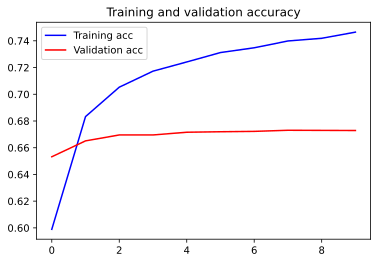

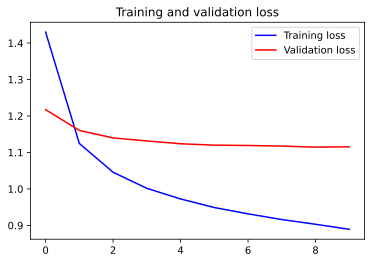

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Где-то на 5-й эпохе сеть переобучилась. Видимо нужно добавить дропаут.

In [31]:
model_2.save('bert_keras_softmax.h5')

In [32]:
# model_2 = tf.keras.models.load_model('/kaggle/input/private-kanavenko/bert_keras_softmax.h5')

In [33]:
x_test = tokenizer(
    text=test['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = False)

In [34]:
predictions_2 = model_2.predict(x={'input_ids': x_test['input_ids']})

1694/1694 [==============================] - 152s 89ms/step


In [35]:
predictions_2

{'genre': array([[6.8136309e-03, 6.4368309e-03, 1.2998841e-02, ..., 2.1535566e-01,
         1.6516706e-03, 1.5342629e-03],
        [2.4023671e-03, 2.0457346e-03, 3.5841942e-03, ..., 2.1783090e-03,
         8.0217246e-04, 8.7146100e-04],
        [2.0502538e-04, 1.0079098e-04, 4.5283872e-04, ..., 1.7575777e-04,
         1.8238778e-04, 2.7941132e-04],
        ...,
        [1.8377648e-03, 7.0842706e-02, 9.3972934e-03, ..., 7.5960467e-03,
         6.6836883e-04, 2.8849810e-03],
        [1.8443892e-03, 4.4958796e-03, 3.0079153e-03, ..., 1.1501897e-02,
         1.0833283e-03, 1.1274311e-03],
        [1.0830455e-03, 3.9559111e-04, 1.2709600e-03, ..., 2.2489708e-03,
         1.0642435e-03, 5.6314556e-04]], dtype=float32)}

In [36]:
np.argmax(predictions_2['genre'][0])

13

In [37]:
print(le.inverse_transform(np.array([21])))

['short']


In [38]:
list(le.inverse_transform(list(range(0, 27))))

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [39]:
predict_proba = pd.DataFrame(predictions_2['genre'], columns=list(le.inverse_transform(list(range(0, 27)))))
predict_proba.to_csv('bert_predict_proba.csv', index=False)
predict_proba.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0.006814,0.006437,0.012999,0.003706,0.002107,0.022626,0.011881,0.004547,0.154690,0.003205,...,0.000638,0.000748,0.005109,0.018067,0.217398,0.000514,0.000572,0.215356,0.001652,0.001534
1,0.002402,0.002046,0.003584,0.011840,0.001663,0.628900,0.002022,0.003396,0.244014,0.043839,...,0.000661,0.002880,0.014430,0.001320,0.018218,0.000629,0.001150,0.002178,0.000802,0.000871
2,0.000205,0.000101,0.000453,0.000185,0.001796,0.000489,0.000268,0.974521,0.002423,0.000576,...,0.000516,0.000930,0.000099,0.000314,0.012672,0.000527,0.000346,0.000176,0.000182,0.000279
3,0.008977,0.000501,0.003151,0.003956,0.002449,0.078387,0.003822,0.007768,0.806844,0.017340,...,0.000750,0.006102,0.028953,0.000827,0.002712,0.001399,0.001113,0.005811,0.002396,0.000614
4,0.020094,0.000724,0.003117,0.001812,0.004668,0.006232,0.009479,0.002906,0.867726,0.004225,...,0.001637,0.001371,0.023373,0.001191,0.001489,0.002002,0.001004,0.009176,0.007534,0.001932


In [40]:
sub_list = []
for i in range(len(predictions_2['genre'])):
    genr = np.argmax(predictions_2['genre'][i])
    sub_list.append(genr)

In [41]:
submission = pd.DataFrame(sub_list, columns=['genre'])

In [42]:
submission

,genre
0,13
1,5
2,7
3,8
4,8
...,...
54195,8
54196,26
54197,5
54198,5


In [43]:
submission = pd.DataFrame({'id':range(1, len(submission)+1),
                           'genre':submission['genre'].values},
                          columns=['id', 'genre'])

In [44]:
submission

,id,genre
0,1,13
1,2,5
2,3,7
3,4,8
4,5,8
...,...,...
54195,54196,8
54196,54197,26
54197,54198,5
54198,54199,5


In [45]:
submission['genre'] = le.inverse_transform(submission['genre'])

In [46]:
submission

,id,genre
0,1,horror
1,2,comedy
2,3,documentary
3,4,drama
4,5,drama
...,...,...
54195,54196,drama
54196,54197,western
54197,54198,comedy
54198,54199,comedy


In [47]:
submission.to_csv('bert_submission.csv', index=False)

Точность пока 0,69 +. 
Нужно еще попробовать fine-tuning и добавить название фильма к обучениию.

<a href="./predict_proba_3.csv"> Download File </a>